This notebook conatins additional experiments with DDIB. THe computations originally were performed on Google Colab. Here we downloaded
- our colored MNIST dataset
- a slightly modified version of DDIB repo
- necessary packages for the work of DDIB

In [ ]:
# !gdown 1G5Fnc-i2EhpofHLTARX8etIHzAFm1tL5
# !unzip -q colored_mnist_dataset.zip
# !gdown 1jgwfnunMJyc07lWyP_7guKi1CJHFHFW_
# !unzip -q for_elfat.zip
# !pip install -e for_elfat/ddib
# !pip install numpy==1.21.6 matplotlib==3.1.3 scikit-image==0.19.3
# !pip install scikit-learn==1.2.0 gdown==4.6.0 mpi4py==3.1.4

In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import plotly.express as px
import time

batch_size = 16
image_size = 32
channels = 3
shape = (batch_size, channels, image_size, image_size)

device = torch.device("cuda:0")

In [3]:
import sys
sys.path.append('/for_elfat/ddib')

import argparse

from guided_diffusion.script_util import model_and_diffusion_defaults
from guided_diffusion import dist_util
from scripts.common import read_model_and_diffusion


def create_argparser():
    defaults = dict(
        task=0,  # 0 to 5 inclusive
        schedule_sampler="uniform",
        lr=1e-4,
        weight_decay=0.0,
        lr_anneal_steps=0,
        batch_size=64,
        microbatch=-1,  # -1 disables microbatches
        ema_rate="0.9999",  # comma-separated list of EMA values
        log_interval=10,
        save_interval=1000,
        resume_checkpoint="",
        use_fp16=False,
        fp16_scale_growth=1e-3,
        image_size=32,
    )
    defaults.update(model_and_diffusion_defaults())
    defaults.update({"image_size": 32})

    return defaults

args = argparse.Namespace(**create_argparser())

model

Logging to /tmp/openai-2024-12-19-11-07-51-643977
Model path: for_elfat/openai-2024-12-15-13-42-53-452013/model026000.pt


/content/for_elfat/ddib/guided_diffusion/dist_util.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return th.load(io.BytesIO(data), **kwargs)
Clipping input data to the

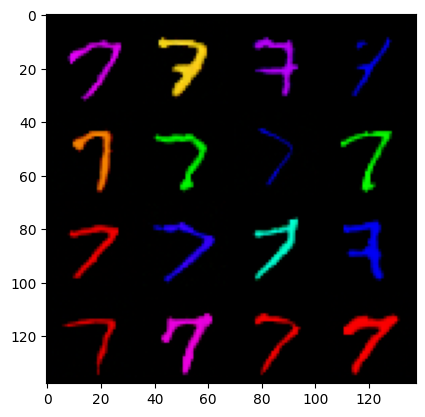

In [5]:
model_dir = "for_elfat/openai-2024-12-15-13-42-53-452013/"
model, diffusion = read_model_and_diffusion(args, model_dir, synthetic=False)

sample = diffusion.ddim_sample_loop(
            model, shape,
            clip_denoised=True,
            device=dist_util.dev(),
        )

grid_img = torchvision.utils.make_grid(sample.detach().cpu(), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

Data

In [16]:
import torch.nn.functional as F

from scripts.colored_mnist_train import get_loader

# Load the dataset
digit = 5
data = get_loader(
    img_folder=f"colored_mnist_dataset/{digit}",
    batch_size=batch_size,
    training=False
)
batch, extra = list(data)[0]

batch = batch.to(device)

grid_img = torchvision.utils.make_grid(batch.detach().cpu(), nrow=4)
px.imshow(grid_img.permute(1, 2, 0))

# Straightforward noise

In [17]:
# First, use DDIM to encode to latents.
print("encoding the source images.")

start = time.time()
noise = diffusion.ddim_reverse_sample_loop(
    model,
    batch,
    clip_denoised=False,
    device=device,
)
end = time.time()

print(f"obtained latent representation for {batch.shape[0]} samples...")
print(f"encoding step takes {end - start} seconds")

encoding the source images.
obtained latent representation for 16 samples...
encoding step takes 44.66536211967468 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


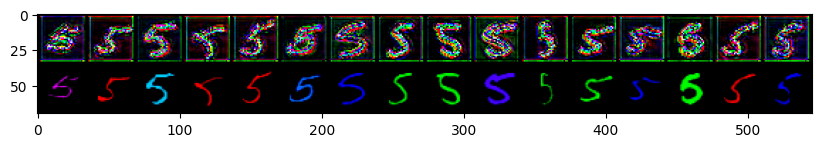

In [31]:
imgs = torch.cat((noise.detach().cpu(), batch.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

plt.savefig('images/noised_fives.png')

denoize

In [33]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=noise,
        clip_denoised=True,
        device=device,
        eta=0
    )
imgs = torch.cat((sample.detach().cpu(), batch.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


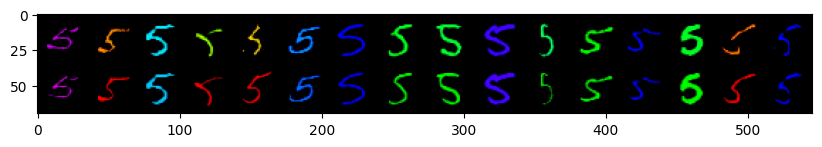

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

plt.savefig('images/restored_fives.png')

# Gaussian blur on noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


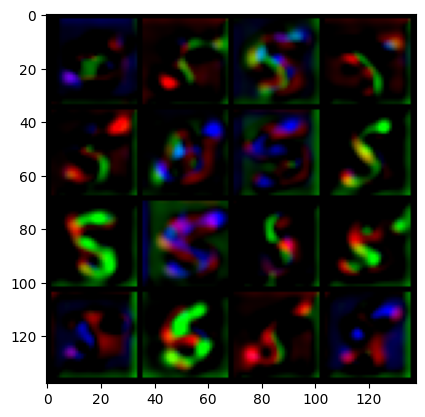

In [35]:
from scipy.ndimage import gaussian_filter


gauss_batch = []
for i in range(noise.shape[0]):
    gauss = gaussian_filter(noise.detach().cpu().numpy()[i], sigma=(0, 2, 2))
    gauss_batch.append(gauss)

gauss_batch = torch.from_numpy(np.stack(gauss_batch)) / 0.6
grid_img = torchvision.utils.make_grid(gauss_batch, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

In [ ]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=gauss_batch.to(device),
        clip_denoised=True,
        device=device,
        eta=0
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


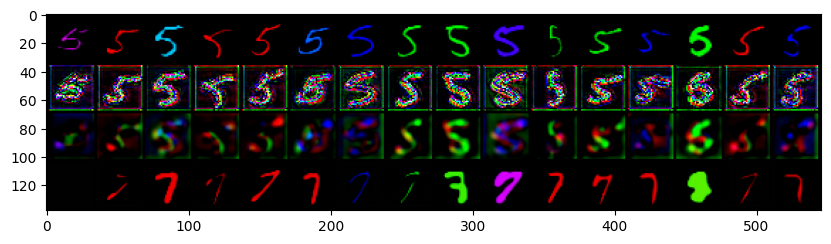

In [40]:
imgs = torch.cat((batch.detach().cpu(), noise.detach().cpu(), gauss_batch.detach().cpu(), sample.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

plt.savefig('images/restored_from_blur.png')

# Blur before noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


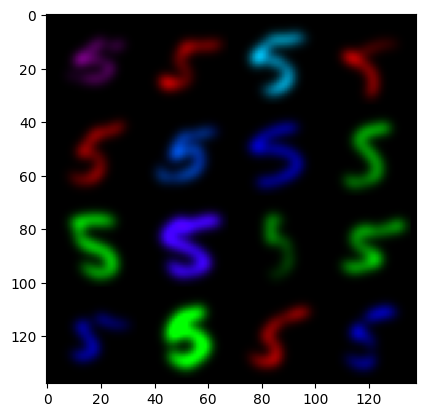

In [41]:
# Blur
gauss_batch = []
for i in range(batch.shape[0]):
    gauss = gaussian_filter(batch.detach().cpu().numpy()[i], sigma=(0, 2, 2))
    gauss_batch.append(gauss)

gauss_batch = torch.from_numpy(np.stack(gauss_batch)) / 0.6
grid_img = torchvision.utils.make_grid(gauss_batch, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


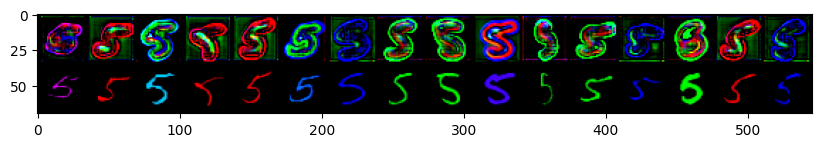

In [42]:
# make noise
noise = diffusion.ddim_reverse_sample_loop(
    model,
    gauss_batch.to(device),
    clip_denoised=False,
    device=device,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


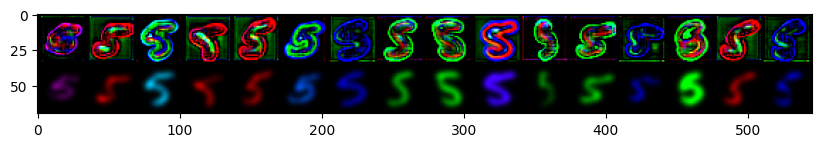

In [43]:
imgs = torch.cat((noise.detach().cpu(), gauss_batch.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

In [44]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=noise,
        clip_denoised=True,
        device=device,
        eta=0
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


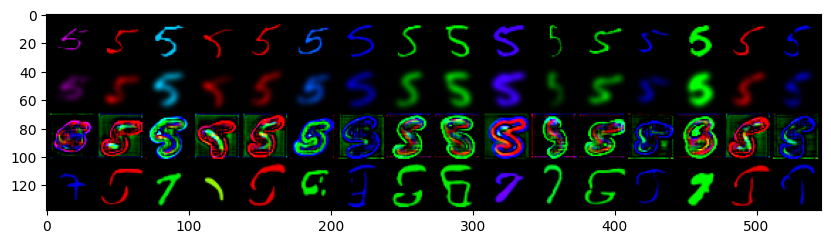

In [46]:
imgs = torch.cat((batch.detach().cpu(), gauss_batch.detach().cpu(), noise.detach().cpu(), sample.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

plt.savefig('images/noised_after_blur.png')

# Now rotate it

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


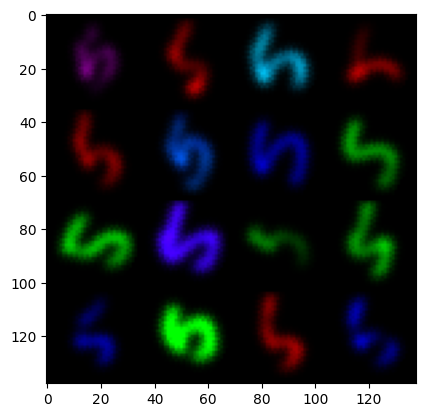

In [50]:
import torchvision.transforms.v2.functional as TF


rotated_batch = TF.rotate(gauss_batch, 60)

grid_img = torchvision.utils.make_grid(rotated_batch, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

In [51]:
# make noise
noise = diffusion.ddim_reverse_sample_loop(
    model,
    rotated_batch.to(device),
    clip_denoised=False,
    device=device,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


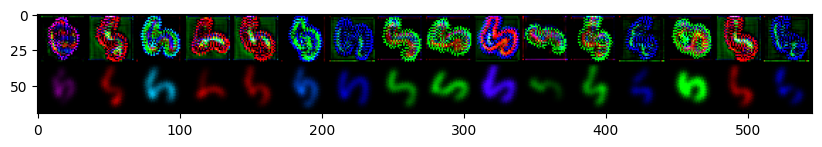

In [52]:
imgs = torch.cat((noise.detach().cpu(), rotated_batch.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

In [53]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=noise,
        clip_denoised=True,
        device=device,
        eta=0
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


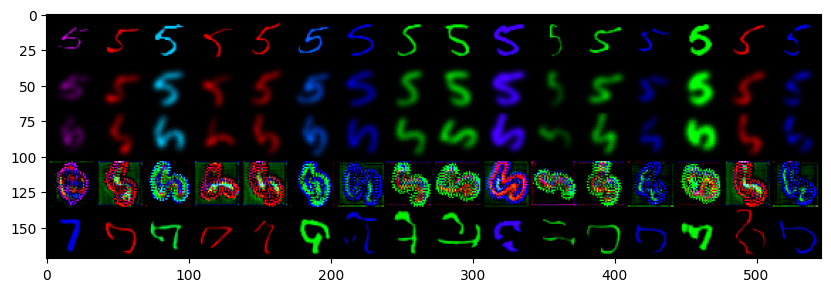

In [55]:
imgs = torch.cat((batch.detach().cpu(), gauss_batch.detach().cpu(), rotated_batch.detach().cpu(), noise.detach().cpu(), sample.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

plt.savefig('images/rotated_blur.png')

# Blur after rotation
We saw that model feels the artefacts of rotation  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


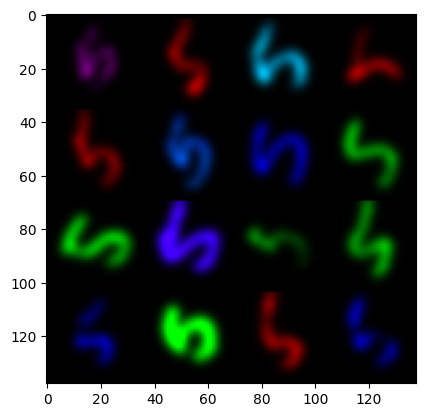

In [56]:
# rotate
rotated_batch = TF.rotate(batch, 60)

# Blur
gauss_batch = []
for i in range(batch.shape[0]):
    gauss = gaussian_filter(rotated_batch.detach().cpu().numpy()[i], sigma=(0, 2, 2))
    gauss_batch.append(gauss)

gauss_batch = torch.from_numpy(np.stack(gauss_batch)) / 0.6

grid_img = torchvision.utils.make_grid(gauss_batch, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


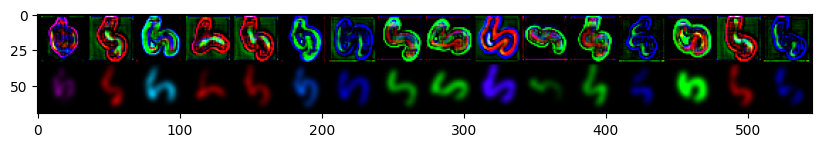

In [57]:
noise = diffusion.ddim_reverse_sample_loop(
    model,
    gauss_batch.to(device),
    clip_denoised=False,
    device=device,
)

imgs = torch.cat((noise.detach().cpu(), gauss_batch.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

In [58]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=noise,
        clip_denoised=True,
        device=device,
        eta=0
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


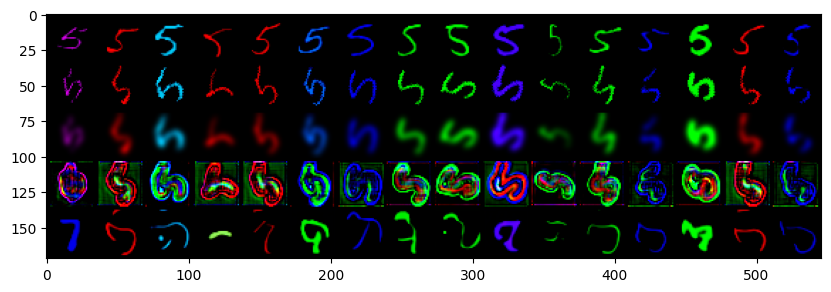

In [60]:
imgs = torch.cat((batch.detach().cpu(), rotated_batch.detach().cpu(), gauss_batch.detach().cpu(), noise.detach().cpu(), sample.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))

plt.savefig('images/blur_after_rotation.png')

# Double blur
We see that it is kinda invariant to rotations, let's blur one more time the noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


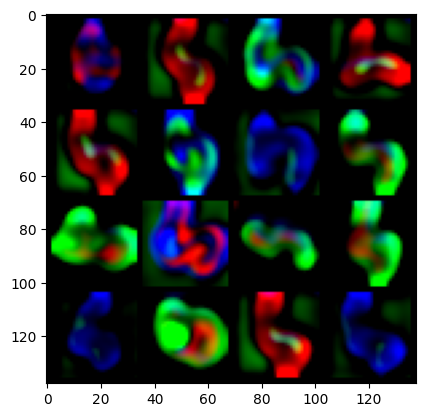

In [61]:
blured_noise = []
for i in range(batch.shape[0]):
    gauss = gaussian_filter(noise.detach().cpu().numpy()[i], sigma=(0, 2, 2))
    blured_noise.append(gauss)

blured_noise = torch.from_numpy(np.stack(blured_noise)) / 0.6

grid_img = torchvision.utils.make_grid(blured_noise, nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))

In [62]:
sample = diffusion.ddim_sample_loop(
        model,
        shape,
        noise=blured_noise.to(device),
        clip_denoised=True,
        device=device,
        eta=0
    )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


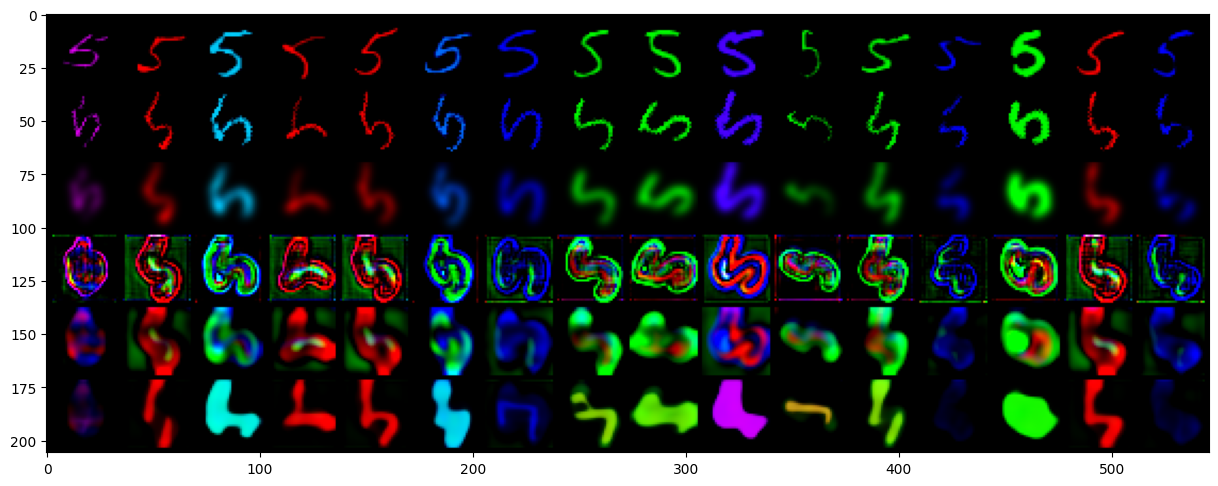

In [64]:
# no result
imgs = torch.cat((batch.detach().cpu(), rotated_batch.detach().cpu(), gauss_batch.detach().cpu(), noise.detach().cpu(),\
                  blured_noise.detach().cpu(), sample.detach().cpu()))
grid_img = torchvision.utils.make_grid(imgs, nrow=16)

plt.figure(figsize=(15, 10))
plt.imshow(grid_img.permute(1, 2, 0))

plt.savefig('images/double_blur.png')

# Modified noise
Model is actually lost by the preserving structure, so we should apply more noise to the latent